In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
plt.rcParams.update({'font.size': 14}) # setting plots font size for clarity
print("Imported Necessary libs")

Imported Necessary libs


In [2]:
# reading the data from the saved excel file
df_main = pd.read_excel(r"D:\Work\Products Databses\personnel\Notebooks\Application of course\all_service_info_30.11.19.xlsx", index_col=[0], parse_Dates=True)

In [3]:
df_main.head()

,nat,job,join,empno,dept,service
leave,,,,,,
2019-09-01,Nepalese,Merchandiser,2017-10-15,2344,General Products Department,1.879452
2019-09-01,Indian,Van Salesman,2014-09-13,1927,Consumer Products Department,4.969863
2019-09-01,Nepalese,Warehouse Asst,2012-05-12,1587,Logistics Department,7.309589
2019-09-01,Sri-Lankan,Sales Supervisor,2006-12-16,1107,Consumer Electronics & Home Appliances Department,12.717808
2019-08-28,Nepalese,Driver,2006-11-30,1093,Logistics Department,12.750685


In [4]:
# delete employee number as we do not need it
df_main.drop(['empno'], axis=1, inplace=True)

In [5]:
# converting index to time series
df_main.index = pd.to_datetime(df_main.index)

### We will start with some assumptions and then we will test them

### 1- We think that employees more than 5 years or more in the company

we will use confidence interval to answer this question

Text(6.616941787446015, 200, 'Average')

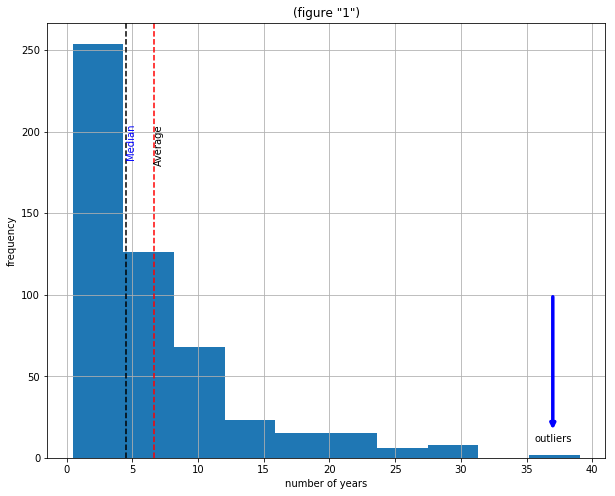

In [6]:
# plotting service period
plt.annotate("outliers",xy=(37, 100),ha='center', xytext=(37, 10), xycoords='data',arrowprops=dict(arrowstyle= '<|-',color='blue',lw=3.5,ls='-'))
df_main['service'].hist(bins=10,figsize=(10,8))
plt.xlabel('number of years')
plt.ylabel('frequency')
plt.title('(figure "1")')
plt.axvline(df_main['service'].median(), color='k', label='Median',linestyle='--')
plt.text(df_main['service'].median(),200,'Median',color='b', rotation=90)
plt.axvline(df_main['service'].mean(), color='r', label='Median',linestyle='--')
plt.text(df_main['service'].mean(),200,'Average',color='k',rotation=90)

The median is 4.4 and the mean is 6.6

we should delete outliers to provide better results

In [7]:
# we remove the outliers by excluding values which are more than 34 years of service
df_nout = df_main.loc[df_main["service"]<35]

In [8]:
# we initiate empty lists to store the values of each sample
lst_mean = []
lst_median = []

for i in range(10000):
    # we take a sample of dataframe that has no outliers with the same size of the main df
    # then we add the mean of service to the list
    sample = df_nout.sample(len(df_main),replace=True)
    lst_mean.append(sample.service.mean())

In [9]:
# we convert the list to numpy array to plot it easily
lst_mean = np.array(lst_mean)

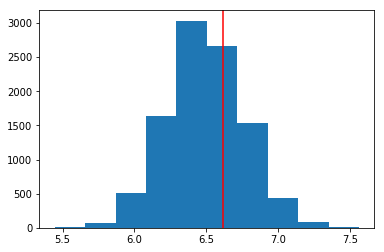

In [10]:
# we plot the list and it takes the shape normal distribution then we draw a line with the real mean of our main dataframe 
# the shown difference between the two means is due to the outliers
plt.hist(lst_mean)
plt.axvline(df_main.service.mean(), color='r')

In [11]:
def confidence_interval(data, confidence_level):
    """This function is to get a confidence interval from a list of values
    **Argumnets:**
        data: list of values - it should be numbers
        confidence_level: is the level of confidence we want to check, it can be 95, 97, 99
    **returns**
        The function returns a tuple of the precentiles of the confidence level
    """
    x = (100 - confidence_level)
    y =  x/2
    return np.percentile(data, y), np.percentile(data, confidence_level + y)

In [12]:
confidence_interval(lst_mean, 95)

(5.976474523727515, 7.031541824540952)

## <u>Conclusion:</u>
### **Within 95% confidence we can say that employees tend to spend more than five years of service in average**

### 2- We will assume that Merchanidsers in General Products Department "GPD" stay more than Merchanidsers in Consumer Products Department "CPD"

### We can represent the null and alternative hypotheses as follows:  
$H$<sub>0</sub> $:$ $GPD$ - $CPD$ $\le$  0   
**The null assumes ther is no change or change on the opposite direction**  

$H$<sub>1</sub> $:$ $GPD$ - $CPD$ $>$  0  
**The alternative hypothesis represents our pre-assumption that gpd is higher**  

In [13]:
# we make our sample distribution using bootstrap method
lst_diff = []
for i in range(10000):
    sample = df_nout.sample(len(df_main),replace=True)
    gpd = sample.loc[(sample["dept"]=="General Products Department") & (sample["job"]=="Merchandiser"),"service"].mean()
    cpd = sample.loc[(sample["dept"]=="Consumer Products Department") & (sample["job"]=="Merchandiser"),"service"].mean()
    lst_diff.append(gpd - cpd)

In [14]:
lst_diff = np.array(lst_diff)

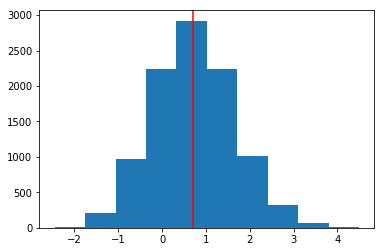

In [15]:
plt.hist(lst_diff)
plt.axvline(lst_diff.mean(), color='r')

In [16]:
# now we simulate the bootstrapped sample with normal distribution
sim_sample = np.random.normal(0, lst_diff.std(), lst_diff.size)

In [17]:
# we get the actual diff of our main dataframe
real_diff = df_main.loc[(df_main["dept"]=="General Products Department") & (df_main["job"]=="Merchandiser"),"service"].mean() - df_main.loc[(df_main["dept"]=="Consumer Products Department") & (df_main["job"]=="Merchandiser"),"service"].mean()

(array([  22.,  185.,  759., 2005., 2927., 2469., 1214.,  366.,   45.,
           8.]),
 array([-3.32688051, -2.61815074, -1.90942097, -1.2006912 , -0.49196142,
         0.21676835,  0.92549812,  1.63422789,  2.34295767,  3.05168744,
         3.76041721]),
 <a list of 10 Patch objects>)

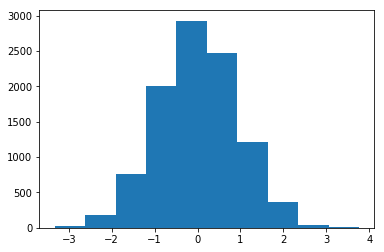

In [18]:
# we plot the simulation of our null hypothesis
plt.hist(sim_sample)

In [19]:
(sim_sample > real_diff).mean()

0.2245

## <u>Conclusion:</u>
### **Our P-value here is more than 5% the signficance level, so we have evidence now to support the null and  we fail to reject it, so there is no statsitical signficance that Merchandisers tend to spend more service years in GPD than in CPD.**

### regression analysis

In [20]:
df_dept_lin = df_main[["job","dept","service"]].query('(dept == "General Products Department" | dept == "Consumer Products Department") & job== "Merchandiser"')

In [21]:
df_dept_lin["intercept"] = 1
df_dept_lin.reset_index(inplace=True)
df_dep_dum = pd.get_dummies(df_dept_lin["dept"])
df_dep_dum.columns = ["cpd","gpd"]
df_dep_dum.head()

,cpd,gpd
0,0,1
1,1,0
2,1,0
3,1,0
4,1,0


In [22]:
df_dept_lin = df_dept_lin.join(df_dep_dum[["cpd","gpd"]])

In [23]:
df_dept_lin.head()

,leave,job,dept,service,intercept,cpd,gpd
0,2019-09-01,Merchandiser,General Products Department,1.879452,1,0,1
1,2019-08-27,Merchandiser,Consumer Products Department,7.104110,1,1,0
2,2019-06-13,Merchandiser,Consumer Products Department,3.791781,1,1,0
3,2019-05-08,Merchandiser,Consumer Products Department,6.427397,1,1,0
4,2019-05-01,Merchandiser,Consumer Products Department,3.361644,1,1,0


In [24]:
lm = sm.OLS(df_dept_lin["service"], df_dept_lin[["intercept","gpd"]]).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                service   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9465
Date:                Thu, 27 Feb 2020   Prob (F-statistic):              0.333
Time:                        11:03:17   Log-Likelihood:                -224.42
No. Observations:                  90   AIC:                             452.8
Df Residuals:                      88   BIC:                             457.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      4.3704      0.357     12.256      0.000       3.662       5.079
gpd            0.7182      0.738      0.973      0.333      -0.749       2.185
==============================================================================
Omnibus:                       38.341   Durbin-Watson:                   1.936
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               84.340
Skew:                           1.594   Prob(JB):                     4.85e-19
Kurtosis:                       6.512   Cond. No.                         2.52
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- ### The coef here indicates that for each one unit in baseline CPD, it increases 0.7 in gpd which is the difference for baseline   
- ### Also our P-value here states that the alternative hypothesis is not statistically significant and we fail to reject the null